# Event finder & raw data checker

This notebook will find competitive cellular "events" in the simplest definition (i.e. a loser cell apoptosis) and return information about the spatiotemporal distrubition of counterpart competitive events (i.e. winner cell mitosis)

Contents:

- Load modules
- Load cell finding functions
- Set experiment data path
- Load image data
- Load tracking data
- Apply necessary coordinate shift for viewer
- Isolate one track of interest (target track)
- Find corresponding tracks/events of interest within a given spatiotemporal range (E.g. if target track is Scr apoptosis, then find all nearby wild-type mitosis)
- Set points and regions of interest for highlighting in Napari viewer(now set as functions so this bit is automatic
- Launch Napari image viewer if desired

To-do:

- [x] Reorganise structure so that scan over all R then filter
- [x] Create radial bins and sort tracks into them
- [ ] Create temporal bins
- [ ] Figure out how to plot said bins into heat map image
- [ ] Check redesigned script against raw data 

In [1]:
import napari
import btrack
import numpy as np
from skimage.io import imread
import os
print("Napari version no.:", napari.__version__)
print("btrack version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON, tracks_to_napari
from tqdm.notebook import tnrange, tqdm
import matplotlib.pyplot as plt

Napari version no.: 0.4.0
btrack version no.: 0.4.0


### Functions to measure local neighbourhood for cells of interest

In [16]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(find_apoptosis_time(target_track, index = False)) ## could also do just ## apop_index
        idx1 = other_track.t.index(frame)
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def find_apoptosis_time(target_track, index): ### if index is set to True then the index of the apoptotic time (wrt target_track) is returned
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            break
    apop_time = target_track.t[apop_index]
    if index == True: 
        return apop_index
    else: 
        return apop_time

def find_nearby_wt_mitosis(target_track, delta_t, radius):
    frame = find_apoptosis_time(target_track, index = False) + delta_t 
    dividing_states = ('METAPHASE',) #('PROMETAPHASE', 'METAPHASE', 'DIVIDE')
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius]
    wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame) if euclidean_distance(target_track, wt_track, frame)<radius if wt_track.label[wt_track.t.index(frame)] in dividing_states if wt_track.fate.name == "DIVIDE"] ###check this
  
    return wt_tracks_in_radius, wt_mitosis_in_radius


def maximum_xyt(i):
    #### BEWARE xy coord switch!     
    if i == 'x':
        max_x = int((max([max(i.y) for i in wt_tracks])))
        return max_x
    if i == 'y':
        max_y = int((max([max(i.x) for i in wt_tracks])))
        return max_y
    if i == 't':
        max_t = int((max([max(i.t) for i in wt_tracks])))
        return max_t
    
def plot_mitoses(): ## this function plots mitosis events into the napari viewer
    apop_event = target_track.t[apop_index], target_track.x[apop_index]+shift_y, target_track.y[apop_index]+shift_x ## with transposed shift
    t_m, x_m, y_m = np.zeros(len(wt_mitosis_in_radius)), np.zeros(len(wt_mitosis_in_radius)), np.zeros(len(wt_mitosis_in_radius))
    mito_events = np.zeros((len(wt_mitosis_in_radius), 3)) ## 3 because of the 3 cartesian coords 
    for i, wt_mitosis in enumerate(wt_mitosis_in_radius): ## this now assumes that the mitosis time point of relevance isnt the last frame of track but the time at delta_t, need to bolster definition of mitosis
        mito_index = [j for j, k in enumerate(wt_mitosis.t) if k == apop_event[0]+delta_t][0] ### [0] bc first item of list comprehension
        t_m[i], x_m[i], y_m[i] = wt_mitosis.t[mito_index], wt_mitosis.x[mito_index]+shift_y, wt_mitosis.y[mito_index]+shift_x ## plus transposed coordinate shift
        mito_events[i] = t_m[i], x_m[i], y_m[i]
    return viewer.add_points(mito_events, name = "Mitosis events", symbol = "cross", face_color = 'pink')

def plot_apoptosis(): ## this function plots apoptotic event and surrounding local environment scope (determined by radius)
    ### add_points needs to be txy
    apop_event = target_track.t[apop_index], target_track.x[apop_index]+shift_y, target_track.y[apop_index]+shift_x ## with transposed shift
    ## apop_circle is the bounding box of the ellipse highlighting radial extent around apoptosis, shown at the shifted time and apop time
    apop_circle = [((apop_event[0]+delta_t, apop_event[1]-radius, apop_event[2]-radius), 
                    (apop_event[0]+delta_t, apop_event[1]+radius, apop_event[2]-radius), 
                    (apop_event[0]+delta_t, apop_event[1]+radius, apop_event[2]+radius), 
                    (apop_event[0]+delta_t, apop_event[1]-radius, apop_event[2]+radius)), 
                    ((apop_event[0], apop_event[1]-radius, apop_event[2]-radius), 
                    (apop_event[0], apop_event[1]+radius, apop_event[2]-radius), 
                    (apop_event[0], apop_event[1]+radius, apop_event[2]+radius), 
                    (apop_event[0], apop_event[1]-radius, apop_event[2]+radius))]
    
    return viewer.add_points(apop_event, name = "Apoptosis event", symbol = 'x', face_color = "c"), viewer.add_shapes(apop_circle, opacity = 0.1, shape_type = 'ellipse', face_color = 'y', name = 'Radial environment')
    


### Set experiment data path 

In [3]:
# print("Input experiment number")
# experiment_no = input()
# root_path = os.path.join('/home/nathan/data/kraken/h2b/giulia/', experiment_no)
root_path = '/home/nathan/data/kraken/h2b/giulia/GV0807'  ## this overwrites input option for ease 
gfp_path = os.path.join(root_path, 'Pos3/stacks/gfp.tif')
rfp_path = os.path.join(root_path, 'Pos3/stacks/rfp.tif')
bf_path = os.path.join(root_path, 'Pos3/stacks/bf.tif')
tracks_path = os.path.join(root_path, 'Pos3/Pos3_aligned/HDF/segmented.hdf5')

### Load image data

In [4]:
gfp = imread(gfp_path)

In [ ]:
rfp = imread(rfp_path)

In [ ]:
#bf = imread(bf_path) #3 large 1000+ frame stacks is usually too much for memory to process on 16gb ram

### Load tracking data

In [22]:
with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_1") as hdf:
    wt_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(tracks_path, 'r', obj_type = "obj_type_2") as hdf:
    scr_tracks = hdf.tracks
print("Tracks loaded")

### finding coord range of aligned images, coords switched already
align_x_range, align_y_range = gfp.shape[2], gfp.shape[1]
### finding maximum extent of tracking coords
tracks_x_range = round(max([max(track.x) for track in wt_tracks]))
tracks_y_range = round(max([max(track.y) for track in wt_tracks])) + 2 ## sort this lazy hack out later

### coord switch
tmp = tracks_y_range
tracks_y_range = tracks_x_range
tracks_x_range = tmp

print("tracks range:", (tracks_x_range), (tracks_y_range))
print("aligned image range:", (align_x_range), (align_y_range))

shift_x = int((align_x_range - tracks_x_range)/2)
shift_y = int((align_y_range - tracks_y_range)/2)

print("shift in x and y:", shift_x, shift_y)

wt_data, properties, graph = tracks_to_napari(wt_tracks, ndim = 2)
scr_data, properties, graph = tracks_to_napari(scr_tracks, ndim = 2)

tmp = wt_data[:,2].copy() ## copy the true_y coord
wt_data[:,2] = wt_data[:,3]  ##assign the old_y coord as the true_x
wt_data[:,3] = tmp ## assign the old_x as true_y

wt_data[:,2] += shift_y ## TRUE_Y (vertical axis)
wt_data[:,3] += shift_x ## TRUE_X (horizontal axis)

tmp = scr_data[:,2].copy()
scr_data[:,2] = scr_data[:,3]
scr_data[:,3] = tmp

scr_data[:,2] += shift_y ## TRUE_Y (vertical axis)
scr_data[:,3] += shift_x ## TRUE_X (horizontal axis)

print("coordinate shift applied")

[INFO][2020/12/08 09:04:58 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/12/08 09:04:58 PM] Loading tracks/obj_type_1
[INFO][2020/12/08 09:05:07 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2020/12/08 09:05:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2020/12/08 09:05:19 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/12/08 09:05:19 PM] Loading tracks/obj_type_2
[INFO][2020/12/08 09:05:19 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2020/12/08 09:05:19 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Tracks loaded
tracks range: 1600 1200
aligned image range: 1739 1377
shift in x and y: 69 88
coordinate shift applied


### Isolate one track of interest

In [6]:
## isolate one target scribble track of interest
print("input scribble track of interest ID")
cell_ID = int(input())
index = [i for i, scr_tracks in enumerate(scr_tracks) if scr_tracks.ID == cell_ID][0]
target_track = scr_tracks[index]##### Show the first classification of each track
apop_index, apop_time = find_apoptosis_time(target_track, index = True), find_apoptosis_time(target_track, index = False)  

input scribble track of interest ID
17


# Find cells of interest

In [25]:
radius = 500
delta_t = -50
wt_tracks_in_radius, wt_mitosis_in_radius = find_nearby_wt_mitosis(target_track, delta_t, radius)

display ID for all tracks found in radius 

In [26]:
print("ID for all tracks in radius:", [j.ID for i, j in enumerate(wt_tracks_in_radius)])
print("ID for all mitoses in radius:", [j.ID for i, j in enumerate(wt_mitosis_in_radius)])

ID for all tracks in radius: [4, 94, 109, 143, 148, 169, 189, 218, 310, 311, 319, 330, 335, 340, 346, 344, 352, 380, 381, 399, 403, 405, 407, 418, 419, 420, 421, 437, 436, 445, 446, 453, 454, 455, 456, 461, 462, 478, 490, 493, 501, 513, 508, 507, 526, 527, 533, 536, 535, 534, 562, 561, 560, 585, 587, 588, 589, 591, 603, 604, 609, 621, 622, 631, 632, 640, 647, 648, 649, 650, 657, 658, 664, 666, 670, 673, 674, 690, 691, 704, 705, 716, 719, 717, 720, 721, 732, 736, 737, 745, 748, 751, 752, 753, 757, 763, 762, 760, 761, 768, 769, 770, 771, 776, 785, 787, 788, 791, 792, 795, 797, 798, 799, 800, 801, 803, 810, 811, 818, 836, 837, 844, 845, 848, 849, 850, 851, 854, 853, 858, 859]
ID for all mitoses in radius: [419, 454]


to-do: 
- [x] take output of wt_tracks_in_radius and bin into discrete distance cats
- [ ] iterate over time... over all frames? NO
- [ ] plot bins into heatmap

# sandbox

In [28]:
t_range = range(-200,200)
wt_mito_ID_temporal_bins = {}

## create bins automatically
num_bins = 10
bin_size = radius / num_bins
## create dict for wt data storage
wt_track_bins = {}
wt_ID_bins = {} ## temp measure to create parallel dict just listing the IDs so that i can check algorithm works against raw data
wt_mitosis_bins = {}
wt_mito_ID_bins = {} ## temp measure to create parallel dict just listing the IDs so that i can check algorithm works against raw data

wt_tracks_in_radius = []
wt_mitosis_in_radius = []

for delta_t in t_range:
    ## creating temporal bin label
    temporal_bin_label = "frame" + str(find_apoptosis_time(target_track, index = False) + delta_t)
    wt_mito_ID_temporal_bins[temporal_bin_label] = {}
    radius = 500 ## maximum radius
    ## count all cells and mitoses within radius at delta_t
   
    wt_tracks_in_radius, wt_mitosis_in_radius = find_nearby_wt_mitosis(target_track, delta_t, radius)
    print("time", delta_t, "wt", len(wt_tracks_in_radius), "mito", len(wt_mitosis_in_radius))## currently returning zero hmmm
    ## iterate over all bins
    for i in range(num_bins):
        ## create bin label for dict entry 
        bin_label = str((bin_size * i)) + "< radial distance <" + str((bin_size * (i+1))) 
        ## create empty list to store each bins data in before storing
        wt_trackz = []
        wt_IDs = [] ## temp measure
        for wt_track in wt_tracks_in_radius:
            if (bin_size * i) <= euclidean_distance(target_track, wt_track, (find_apoptosis_time(target_track, index = False) + delta_t)) <= (bin_size*(i+1)):
                ## add track info to list for saving in dict bin entry
                wt_trackz.append(wt_track) 
                wt_IDs.append(wt_track.ID) ## temp measure
        ## add list of cells to dict entry
        wt_track_bins[bin_label] = wt_tracks
        wt_ID_bins[bin_label] = wt_IDs

        wt_mito_IDs = [] ## temp measure
        wt_mitos = []
        for wt_mito in wt_mitosis_in_radius:
            if (bin_size * i) <= euclidean_distance(target_track, wt_mito, (find_apoptosis_time(target_track, index = False) + delta_t)) <= (bin_size*(i+1)):
                ## add track info to list for saving in dict bin entry
                wt_mitos.append(wt_mito) 
                wt_mito_IDs.append(wt_mito.ID) ## temp measure
        ## add list of cells to dict entry
        wt_mitosis_bins[bin_label] = wt_mitos
        wt_mito_ID_bins[bin_label] = wt_mito_IDs
        #print(wt_mito_IDs, delta_t)
        
        #wt_mito_ID_temporal_bins[temporal_bin_label][bin_label] = wt_mito_IDs

time -200 wt 71 mito 0
time -199 wt 71 mito 0
time -198 wt 73 mito 0
time -197 wt 73 mito 0
time -196 wt 72 mito 0
time -195 wt 72 mito 1
time -194 wt 72 mito 1
time -193 wt 72 mito 1
time -192 wt 71 mito 1
time -191 wt 72 mito 0
time -190 wt 72 mito 2
time -189 wt 72 mito 1
time -188 wt 73 mito 1
time -187 wt 72 mito 1
time -186 wt 73 mito 1
time -185 wt 74 mito 1
time -184 wt 74 mito 1
time -183 wt 74 mito 1
time -182 wt 74 mito 1
time -181 wt 74 mito 2
time -180 wt 75 mito 1
time -179 wt 75 mito 1
time -178 wt 75 mito 1
time -177 wt 74 mito 1
time -176 wt 75 mito 0
time -175 wt 77 mito 1
time -174 wt 77 mito 3
time -173 wt 78 mito 2
time -172 wt 78 mito 2
time -171 wt 78 mito 1
time -170 wt 78 mito 0
time -169 wt 79 mito 0
time -168 wt 80 mito 1
time -167 wt 79 mito 0
time -166 wt 79 mito 2
time -165 wt 79 mito 3
time -164 wt 79 mito 4
time -163 wt 79 mito 4
time -162 wt 79 mito 3
time -161 wt 79 mito 3
time -160 wt 80 mito 1
time -159 wt 81 mito 0
time -158 wt 81 mito 0
time -157 w

time 161 wt 251 mito 3
time 162 wt 252 mito 5
time 163 wt 253 mito 4
time 164 wt 254 mito 2
time 165 wt 254 mito 4
time 166 wt 253 mito 3
time 167 wt 254 mito 5
time 168 wt 256 mito 4
time 169 wt 257 mito 3
time 170 wt 258 mito 4
time 171 wt 259 mito 6
time 172 wt 261 mito 6
time 173 wt 263 mito 5
time 174 wt 263 mito 6
time 175 wt 264 mito 5
time 176 wt 264 mito 5
time 177 wt 266 mito 5
time 178 wt 261 mito 6
time 179 wt 261 mito 4
time 180 wt 261 mito 5
time 181 wt 262 mito 6
time 182 wt 263 mito 5
time 183 wt 263 mito 10
time 184 wt 266 mito 7
time 185 wt 267 mito 8
time 186 wt 267 mito 8
time 187 wt 269 mito 3
time 188 wt 271 mito 3
time 189 wt 273 mito 2
time 190 wt 271 mito 3
time 191 wt 271 mito 2
time 192 wt 273 mito 1
time 193 wt 274 mito 2
time 194 wt 273 mito 2
time 195 wt 272 mito 3
time 196 wt 271 mito 3
time 197 wt 273 mito 1
time 198 wt 274 mito 3
time 199 wt 274 mito 4


In [29]:
wt_mito_ID_temporal_bins

{'frame530': {'0.0< radial distance <50.0': [],
  '50.0< radial distance <100.0': [],
  '100.0< radial distance <150.0': [],
  '150.0< radial distance <200.0': [],
  '200.0< radial distance <250.0': [],
  '250.0< radial distance <300.0': [],
  '300.0< radial distance <350.0': [],
  '350.0< radial distance <400.0': [],
  '400.0< radial distance <450.0': [],
  '450.0< radial distance <500.0': []},
 'frame531': {'0.0< radial distance <50.0': [],
  '50.0< radial distance <100.0': [],
  '100.0< radial distance <150.0': [],
  '150.0< radial distance <200.0': [],
  '200.0< radial distance <250.0': [],
  '250.0< radial distance <300.0': [],
  '300.0< radial distance <350.0': [],
  '350.0< radial distance <400.0': [],
  '400.0< radial distance <450.0': [],
  '450.0< radial distance <500.0': []},
 'frame532': {'0.0< radial distance <50.0': [],
  '50.0< radial distance <100.0': [],
  '100.0< radial distance <150.0': [],
  '150.0< radial distance <200.0': [],
  '200.0< radial distance <250.0': [],

plotting wt_mito_ID_temporal_bins

In [49]:
wt_mito_ID_temporal_bins['frame685']

{'0.0< radial distance <50.0': [],
 '50.0< radial distance <100.0': [849],
 '100.0< radial distance <150.0': [792],
 '150.0< radial distance <200.0': [399],
 '200.0< radial distance <250.0': [403, 589, 811],
 '250.0< radial distance <300.0': [311, 691, 705, 737],
 '300.0< radial distance <350.0': [4, 622, 648, 690],
 '350.0< radial distance <400.0': [621, 664, 704],
 '400.0< radial distance <450.0': [143, 169, 310, 446, 533, 647],
 '450.0< radial distance <500.0': [418, 493, 562, 609]}

In [109]:
heatmap = np.zeros((10,400))

for i, key1 in enumerate(wt_mito_ID_temporal_bins.keys()):
    #print(i, key1)
    for j, key2 in enumerate(wt_mito_ID_temporal_bins['frame685'].keys()):
        #print(j,key2)
        if len(wt_mito_ID_temporal_bins[key1][key2]) > 4:
            print(key1, key2)
            print(len(wt_mito_ID_temporal_bins[key1][key2]))
        heatmap[j,i] = len(wt_mito_ID_temporal_bins[key1][key2])
#heatmap[:,0] = wt_mito_ID_temporal_bins[i][j]

frame685 400.0< radial distance <450.0
6
frame737 400.0< radial distance <450.0
7
frame737 450.0< radial distance <500.0
5


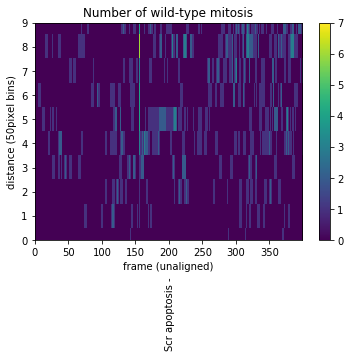

In [103]:
plt.imshow(heatmap, cmap= 'viridis', aspect = 'auto')#, #interpolation = 'nearest')
plt.colorbar()
plt.ylim(0,9)
#plt.xlim(0,10)
#plt.clim(0,3)
plt.title("Number of wild-type mitosis")
plt.text(195,-4.5, "Scr apoptosis -", rotation=90)
plt.xlabel("frame (unaligned)")
plt.ylabel("distance (50pixel bins)")
plt.savefig("/home/nathan/data/number_heatmap_Scr17.pdf", transparent=True, bbox_inches="tight", pad_inches=0.25, dpi = 300)
plt.show()

### Launch napari to check against raw data 

In [ ]:
with napari.gui_qt():
    viewer = napari.Viewer()
    
    #viewer.add_image(bf)
    viewer.add_image(gfp, name="gfp", blending = "additive", colormap = "green")
    viewer.add_image(rfp, name="rfp", contrast_limits = (0, 50), blending = "additive", colormap = "red")
    
    viewer.add_tracks(wt_data)
    viewer.add_tracks(scr_data)
    
    plot_mitoses() ## utilises two functions above to plot apop and mito 
    plot_apoptosis()
    viewer.dims.set_point(0, (apop_time + delta_t)) ## open viewer at the timepoint of interest